In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import math
from PIL import Image
import ipywidgets as widgets
from IPython.display import display

In [2]:
def read_labels(path):
    with open(path, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        return np.fromfile(flbl, dtype=np.uint8).reshape((num,))

In [3]:
def read_images(path):
    with open(path, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        rows, cols = struct.unpack(">II", flbl.read(8))
        return np.fromfile(flbl, dtype=np.uint8).reshape((num, rows * cols))

In [4]:
rx_train = read_images('train-images-idx3-ubyte')
ry_train = read_labels('train-labels-idx1-ubyte')
rx_test = read_images('t10k-images-idx3-ubyte')
ry_test = read_labels('t10k-labels-idx1-ubyte')

In [5]:
def gen(n):
    x = np.random.rand(n, 1)
    y = (x > 0.5) * 1
    return x, y

In [6]:
def norm(X):
    e = np.mean(X)
    s = np.std(X)
    return (X - e) / s, lambda x: (x - e) / s

In [7]:
def one_hot(y):
    return np.eye(1, 10, y)[0]
def one_hot_all(Y):
    return np.array([one_hot(y) for y in Y])

In [8]:
# x_train = rx_train.reshape((len(rx_train), 28 * 28))
x_train = rx_train / 255
x_test = rx_test / 255

# x_train, bnorm = norm(x_train)
y_train = one_hot_all(ry_train)

In [9]:
def sigmoid(x):
    return (1 / (1 + np.exp(-x))).reshape((len(x),))
def sigmoid_prime(x):
    s = sigmoid(x)
    return (s * (1 - s)).reshape((len(x),))
def soft_relu(x):
    return np.log(1 + np.exp(x)).reshape((len(x),))
def soft_relu_prime(x):
    return sigmoid(x)
def tanh(x):
    return (2 / (1 + np.exp(-2 * x)) - 1).reshape((len(x),))
def tanh_prime(x):
    return (1 - tanh(x) ** 2).reshape((len(x),))

In [10]:
class Layer:
    def __init__(self, n, activation, activation_prime):
        self.n = n
        self.activation = activation
        self.activation_prime = activation_prime
        self.c = np.random.rand(n) * 2 - 1
    def z(self, x):
        return self.w.dot(x) + self.c
    def a(self, x):
        return self.activation(x)
    
    def process(self, x):
        self.last_z = self.z(x)
        self.last_a = self.a(self.last_z)
        return self.last_a

In [11]:
def J(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred), axis = -1)
def J_prime(y_true, y_pred):
    return (y_pred - y_true).reshape((len(y_true),))

In [18]:
class MyNN:
    def __init__(self, n):
        self.n = n
        self.layers = []
        
    def add(self, layer):
        nl1 = layer.n
        nl = self.layers[-1].n if self.layers else self.n
        layer.w = np.random.rand(nl1, nl) * 2 - 1
        self.layers.append(layer)
    
    def fit(self, X, Y, batch_size, learning_rate, epochs, decay, moment, verbose):
        w_moment = [np.zeros_like(l.w) for l in self.layers]
        c_moment = [np.zeros_like(l.c) for l in self.layers]
        
        if verbose:
            epch_widg = widgets.IntText(disabled=True, description = 'epoch:  ')
            loss_widg = widgets.FloatText(disabled=True, description = 'loss, %:  ')
            progr_widg = widgets.FloatProgress(min = 0, max = 1, step = 0.01, description = 'progress:  ')
            display(epch_widg)
            display(loss_widg)
            display(progr_widg)
            
        
        for epoch in range(epochs):
            for _ in range(math.ceil(len(X) / batch_size)):
                chs = np.random.choice(len(X), batch_size)
                x_batch = X[chs]
                y_batch = Y[chs]
    
                grad_w = [np.zeros_like(l.w) for l in self.layers]
                grad_c = [np.zeros_like(l.c) for l in self.layers]
                
                m = len(self.layers)
    
                for x, y in zip(x_batch, y_batch):
                    y_pred = self.predict(x)
                    
                    l = self.layers[-1]
                    l_sgmp = l.activation_prime
    
                    delta = [None] * m
                    delta[-1] = J_prime(y_true=y, y_pred=y_pred) * l_sgmp(l.last_z)
                    
                    for i in range(m - 2, -1, -1):
                        l = self.layers[i]
                        l_sgmp = l.activation_prime
                        
                        lnext = self.layers[i + 1]
                        delta[i] = lnext.w.T.dot(delta[i + 1]) * l_sgmp(l.last_z)
    
                    #calc grad c
                    for g, d in zip(grad_c, delta):
                        g += d
                    
                    #calc grad w
                    for i in range(0, m):
                        if i == 0:
                            aprev = x
                        else:
                            aprev = self.layers[i - 1].last_a
                        l = self.layers[i]
                        
                        grad_w[i] += delta[i][:, np.newaxis].dot(aprev[:, np.newaxis].T)
                        
                for l, gr_w, gr_m_w, gr_c, gr_m_c in zip(self.layers, grad_w, w_moment, grad_c, c_moment):
                    gr_m_w *= moment
                    gr_m_w += (1 - moment) * learning_rate * gr_w / batch_size
                    l.w -= gr_m_w
                    
                    gr_m_c *= moment
                    gr_m_c += (1 - moment) * learning_rate * gr_c / batch_size
                    l.c -= gr_m_c
                    
#             clear_output()
#             y_pred = np.array([self.predict_d(x) for x in X])
#             print('error loss:', J(Y, y_pred).sum(axis = 0))
    #                 print('error loss:', (Y != ((y_pred > 0) * 2 - 1)).sum(axis = 0))
            learning_rate -= decay
            
            wsum = sum([np.argmax(y) != self.predict_d(x) for x, y in zip(X, Y)])
#             wsum = sum([y != (self.predict(x)[0] > 0) * 2 - 1 for x, y in zip(X, Y)])

            if verbose:
                epch_widg.value = epoch
                loss_widg.value = wsum / len(X) * 100
                progr_widg.value = epoch / epochs
    
    #                 for x1, y1 in zip(cx, cy):
    #                     plt.plot(x1[0], x1[1], 'ro' if self.predict(x1) > 0 else 'bo')
    #                 plt.show()

    def predict(self, a):
        for l in self.layers:
            a = l.process(a)
        return a
    
    def predict_d(self, x):
        y = self.predict(x)
        return np.argmax(y)

In [19]:
sx_train = x_train
sy_train = y_train * 2 - 1

In [20]:
nn = MyNN(28 * 28)
nn.add(Layer(30, tanh, tanh_prime))
nn.add(Layer(15, tanh, tanh_prime))
nn.add(Layer(10, tanh, tanh_prime))
nn.fit(sx_train, sy_train, 200, 0.04, 100, 0, 0.7, True)

In [22]:
nn.fit(sx_train, sy_train, 200, 0.04, 100, 0, 0.7, True)

In [23]:
nn.fit(sx_train, sy_train, 100, 0.05, 100, 0, 0.2, True)

In [ ]:
6

In [ ]:
for x, y, i in zip(x_test, ry_test, range(len(x_test))):
    print(y, nn.predict_d(x))
    im = x.reshape((28, 28))
    plt.imshow(im, plt.cm.Greys)
    plt.show()
    input()

In [24]:
wsum = sum([y != nn.predict_d(x) for x, y in zip(x_test, ry_test)])
wsum / len(ry_test)

0.071999999999999995

1


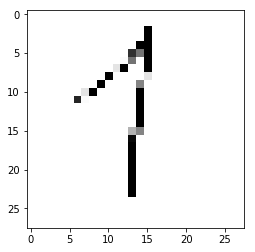

In [29]:
im = Image.open('img.png')
x = 255 - np.array(im.resize((28, 28)))[:, :, 0]
y = one_hot(int(input()))
plt.imshow(x, cmap=plt.cm.Greys)
x = x.flatten() / 255
plt.show()

In [31]:
nn.predict_d(x)

3